In [299]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [300]:
class field():
    def __init__(self, ncells):
        self.nghost = 2
        self.ncells = ncells
        self.cc = np.zeros(ncells+self.nghost)
        self.cfVals_left = np.zeros(ncells+1)
        self.cfVals_right = np.zeros(ncells+1)
        self.derivative = np.zeros(ncells)
        self.a = np.zeros(ncells+1)
        self.ccVals = self.cc[0+int(0.5*self.nghost):-1*int(0.5*self.nghost)] #This is mostly for internal use
        
    def setInitCond(self,fvals):
        self.ccVals = fvals
        self.cc[0+int(0.5*self.nghost):-1*int(0.5*self.nghost)] = fvals
        
    def computeDerivative(self, dx, theta = 1.0):
        self.derivative =  (1.0/dx)*minmod((theta)*(self.cc[1:-1] - self.cc[0:-2]), \
                                  (0.5)*(self.cc[2:] - self.cc[:-2]), \
                                  (theta)*(self.cc[2:] - self.cc[1:-1]))
        
    def updateStuff(self):
        self.cc[0+int(0.5*self.nghost):-1*int(0.5*self.nghost)] = self.ccVals
        
    def setGhostCellValues(self, vals):
        if self.nghost == 2:
            self.cc[0] = vals[0]
            self.cc[-1] = vals[1]
        else:
            print('Changed number of ghost cells, update them!')

    def computeCellFaceValues(self, dx):
        self.computeDerivative(dx)
        self.cfVals_left[0] = self.cc[0]
        self.cfVals_left[1:] = self.ccVals + 0.5*dx*self.derivative
        self.cfVals_right[-1] = self.cc[-1]
        self.cfVals_right[:-1] = self.ccVals - 0.5*dx*self.derivative
        
    def computeFluxes(self, dx):
        self.computeCellFaceValues(dx)
        
        self.a = computeLocalSpeed(self)
        
        self.flux_jphalf = 0.5*(fluxFn(self.cfVals_right[1:]) + fluxFn(self.cfVals_left[1:]) \
                                - self.a[1:]*(self.cfVals_right[1:] - self.cfVals_left[1:]))
        
        self.flux_jmhalf = 0.5*(fluxFn(self.cfVals_right[:-1]) + fluxFn(self.cfVals_left[:-1]) \
                                - self.a[:-1]*(self.cfVals_right[:-1] - self.cfVals_left[:-1]))
        self.FinalFlux = -(self.flux_jphalf - self.flux_jmhalf)/dx
        
        
#------------------------------------------------------------------------------------------
class domain:
    def __init__(self, ncells, endpts):
        self.ncells = ncells
        self.xLeft = endpts[0]
        self.xRight = endpts[1]
        self.dx = (self.xRight - self.xLeft)/self.ncells
        self.x_cc = np.linspace(self.xLeft+self.dx, self.xRight-self.dx, ncells)
#-------------------------------------------------------------------------------------------
                
#-------------------------------------------------------------------------------------------
def minmod(a, b, c):
    result = np.zeros(len(a))
    overall = np.array([a, b, c])
    signs = np.prod(np.sign(overall),0)
    result[signs > 0] = np.amax(overall[:, signs > 0], 0)
    result[signs < 0] = np.amin(overall[:, signs < 0], 0)
    return result   
#-------------------------------------------------------------------------------------------
def fluxFn(u):
    return (0.5*u**2)

#-------------------------------------------------------------------------------------------
def computeLocalSpeed(u_field):
    #This changes if the above function changes
    return np.amax(np.array([u_field.cfVals_left,u_field.cfVals_right]),0)

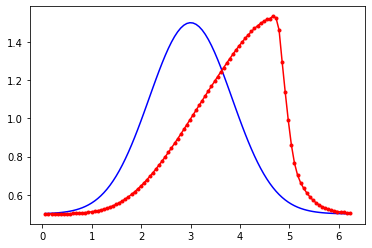

In [301]:
#Domain setup
x = domain(100, np.array([0,2*np.pi]))

#Field setup
u = field(x.ncells)
utemp = field(x.ncells)

#Initial conditions
initC = lambda x: 0.5 + np.exp((-(x - 3.0)**2)/1.4)#1.0*(x < 0.5) + 1.0*(x > -0.5)
u.setInitCond(initC(x.x_cc))
u.setGhostCellValues(np.array([0.5,0.5]))

utemp.setInitCond(initC(x.x_cc))
utemp.setGhostCellValues(np.array([0.5,0.5]))


plt.figure()
t = 0.0
tFinal = 1.0
dt = 0.02
plt.plot(x.x_cc, u.ccVals,'b')
while t < tFinal:
    #print("Time:",t)
    
    '''    
    utemp.computeFluxes(x.dx)
    
    utemp.ccVals = utemp.ccVals + dt*utemp.FinalFlux
    utemp.updateStuff()
    
    uxtemp.ccVals = computeUx(utemp)/x.dx
    utemp.computeCellFaceValues(uxtemp, x.dx)
    a = computeLocalSpeed(utemp)
    utemp.computeFluxes(a,x.dx)
    ''' 
    
    utemp.computeFluxes(x.dx)
    u.computeFluxes(x.dx)
    
    utemp.ccVals = utemp.ccVals + dt*utemp.FinalFlux
    utemp.updateStuff()
    utemp.computeFluxes(x.dx)
    
    u.ccVals = u.ccVals + 0.5*dt*(u.FinalFlux + utemp.FinalFlux)
    #u.ccVals = u.ccVals + dt*(u.FinalFlux)
    u.updateStuff()
    utemp.cc = u.cc
    
    #Lax-Friedrichs scheme
    #uLxF[1:-1] = 0.5*(uLxF[2:] + uLxF[:-2]) - 0.5*(dt/dx)*(fluxFn(uLxF[2:]) - fluxFn(uLxF[:-2]))
    t = t + dt
plt.plot(x.x_cc, u.ccVals,'r.-')#, x,uLxF[1:-1],'g*')
plt.show()